
# Exploring Urban Areas with k-Means Clustering (Geemap)
Master's in Automation and Robotics - ETSII (UPM) \
*Subject:* Artificial Intelligence\
*Course:* 2023-24\
*Student Name (ID):*
* Jorge Guijarro (23075)
- Josep Mª Barberá (17048)

*Date:* January, 14

# Package installation and initial configuration

In [3]:
#!pip install geemap #Uncomment if not installed
import ee
import geemap

import numpy as np
import matplotlib.pyplot as plt

#Creation of the Environment Map

In [4]:
# Create the map
Map = geemap.Map()

# Select the interest point
point =  ee.Geometry.Point([-74.99597,40.9089 ]) #New York
#point =  ee.Geometry.Point([-106.65114,35.08449 ]) #Albuquerque
#point =  ee.Geometry.Point([2.3486000,48.8534000]) #Paris
#point =  ee.Geometry.Point([-4.0226300, 39.8581000]) #Madrid and Toledo


#Create a collection of Landsat images, removing clouds and filtering by bands.
image = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(point)
    .filterDate('2016-01-01', '2017-01-01')
    .sort('CLOUD_COVER')
    .first()
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
)

# Create an interactive map and add Landsat imagery
Map.centerObject(point,7)
Map.addLayer(image, {'min': 0, 'max': 3000, 'bands': ['B5', 'B4', 'B3']}, "Landsat-8")

# Show interactive map
Map

Map(center=[40.9089, -74.99597], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

#Supervised Classification

Firstly, the training data is created through the *sample* function, applying the data coming from the NLCD dataset (https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD).

Once this is done, the information of interest will be obtained by superimposing the points of the selected image with the training data. Then, a CART (Classification And Regression Tree) classifier is used to train the model with these samples, using this classifier in the input image to determinate the classes. Finally, the values and class palette of the original NLCD layer are obtained and this information is used to visualize the classification on the map and establish a legend.

Based on: https://geemap.org/notebooks/32_supervised_classification/



#### Training + Classification

In [15]:
# Training Phase
# Load Dataset
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('landcover').clip(image.geometry())
# The ids of the classes of the dataset are selected
ids = nlcd.get('landcover_class_values').getInfo()
# Classes are rearranged for easy interpretation
n = len(ids)
new_class = list(range(0, n))
# Color codes are obtained for each class
class_color = nlcd.get('landcover_class_palette').getInfo()
# The ids are adjusted with the new tags
nlcd = nlcd.remap(ids, new_class).select(
    ['remapped'], ['landcover']
)
# The training is initialized with the new ids values.
nlcd = nlcd.set('landcover_class_values', new_class)
nlcd = nlcd.set('landcover_class_palette', class_color)
points = nlcd.sample(
    region=image.geometry(),
    scale=30,
    numPixels=5000,
    seed=0,
    geometries=True,
)
# Update training data on the map
Map.addLayer(nlcd, {}, 'NLCD')

# Training the classifier
# Overlay the points to get training.
Overlapping_points = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']).sampleRegions(
    collection=points,
    properties=['landcover'],
    scale=30
)
# A training/validation threshold is established (90% of the data will go to training and 10% to validation). it will be used for validation section
Threshold = Overlapping_points.randomColumn()
split = 0.9
training = Threshold.filter(ee.Filter.lt('random', split))
validation = Threshold.filter(ee.Filter.gte('random', split))

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, 'landcover', ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'])

# Classify
# Classify the using the Band of the training
result = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']).classify(trained)
# Draw categorical map according to the established classes.
landcover = result.set('classification_class_values', new_class).set('classification_class_palette', class_color)
Map.addLayer(landcover, {}, 'Land cover')
# Establish the legend and represent the map
Map.add_legend(builtin_legend='NLCD')
Map

Map(bottom=12597.0, center=[40.9089, -74.99597], controls=(WidgetControl(options=['position', 'transparent_bg'…

#### Validation and Class ratios



Training Data

In [11]:
# Create a confusion matrix (predicted data/actual data) and get its precision. It will be used the training data
train_accuracy = trained.confusionMatrix()
train_accuracy.getInfo()
train_accuracy.accuracy().getInfo()

1

Validation Data

In [12]:
# Create a confusion matrix (predicted data/actual data) and get its precision. It will be used the validation data
validated = validation.classify(trained)
test_accuracy = validated.errorMatrix('landcover', 'classification')
test_accuracy.getInfo()
test_accuracy.accuracy().getInfo()

0.41935483870967744

Ratios

In [16]:
# Get the total number of pixels in the region of interest.
totalPixels = image.select(0).reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=image.geometry(),
    scale=30,
    maxPixels=1e13
).get('B1')
# Count pixels for each category.
classCounts = result.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=image.geometry(),
    scale=30,
    maxPixels=1e13
)
# Get the result as a dictionary.
classCountsInfo = ee.Dictionary(ee.Feature(None, classCounts).get('classification'))
# Get the ratios directly from classCountsInfo
class_counts_info = classCountsInfo.getInfo()

# The proportions are obtained for each id
proportions = {}
for key, value in class_counts_info.items():
    proportions[key] = value / totalPixels.getInfo()
# Previously defined classes are grouped to simplify the results. 
urban_classes = ['2', '3', '4', '5']
water_classes = ['0', '1']
dry_classes = ['10', '11', '16', '17']
grassland_classes = ['12', '13', '14', '15']
forest_classes = ['7', '8', '9']
mountain_classes = ['6']

# Sum of the proportions of the specified classes
class_lists = [urban_classes, water_classes, dry_classes, grassland_classes, forest_classes, mountain_classes]
class_names = ['Urban', 'Water', 'Dry', 'Grassland', 'Forest', 'Mountain']
sum_other_classes = 0
for class_list, class_name in zip(class_lists, class_names):
    class_sum = 0
    for key in class_list:
        class_sum += proportions.get(key, 0)
    print(f"Sum of proportions for {class_name} area: {class_sum * 100} %")
    # Add for the other categories
    sum_other_classes += class_sum

# Print the sum for other categories
print(f"Sum of proportions for Other categories: {100 - sum_other_classes * 100} %")

Sum of proportions for Urban area: 30.123529057142463 %
Sum of proportions for Water area: 12.461425161703419 %
Sum of proportions for Dry area: 15.966533137701818 %
Sum of proportions for Grassland area: 0.5724431684186775 %
Sum of proportions for Forest area: 29.680681893471483 %
Sum of proportions for Mountain area: 0.306905763074594 %
Sum of proportions for Other categories: 10.888481818487534 %


#Unsupervised Classification

Firstly, the training data is created through the *sample* function applied to our image of interest. Once the training is completed, we proceed to select the number of clusters using the "*elbow method*", an heuristic technique based on the realization of an inertia-cluster graph, so that the number of clusters for which the variation of the inertia begins to stabilize will be selected. Once this is done, using the function *cluster*, the clustering algorithm is applied as such, segmenting by groups the different pixels of the trained image according to their characteristics. Once this is done, the legend is configured according to the number of clusters and the program is completed.

Based on: https://geemap.org/notebooks/31_unsupervised_classification/

#### Training

In [9]:
# Training the dataset
training = image.sample(
    **{
        'scale': 30,
        'numPixels': 5000,
        'seed': 0,
        'geometries': True,
    }
)
# The working coordinates are determined
coords = np.array(training.geometry().coordinates().getInfo())

#### Determinate Cluster Number

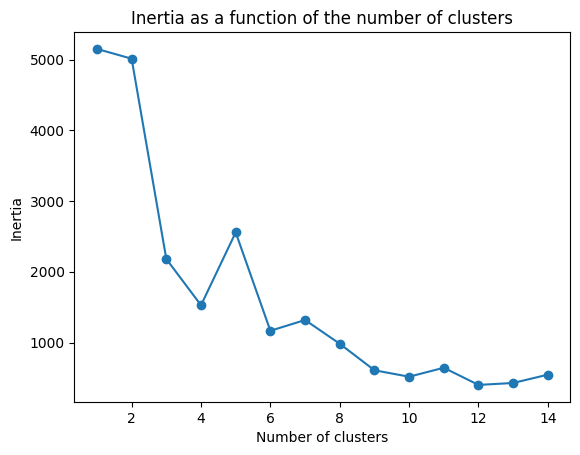

In [ ]:
inertia_values = []
np.random.seed(2) # A fixed random number seed is set to obtain consistent results.

for n_clusters in range(1, 15):  # The graph will be plotted from 1 cluster to 15.
    centroids = coords[np.random.choice(len(coords), size=n_clusters, replace=False)] #Random cluster centroids for each number of clusters
    distances_squared = np.sum((coords[:, np.newaxis] - centroids) ** 2, axis=2) # Calculate the squared distances between each point and the centroids.
    labels = np.argmin(distances_squared, axis=1)# Allocate each point to the nearest cluster
    inertia = np.sum(distances_squared[np.arange(len(coords)), labels])# Calculate the inertia as the sum of the squared distances
    inertia_values.append(inertia)

# Plotting inertia as a function of the number of clusters
plt.plot(range(1, 15), inertia_values, marker='o')
plt.title('Inertia as a function of the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Classification

In [10]:
# Instantiate the clusterer and train it.
n_clusters = 14
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)
# Cluster the input using the trained clusterer.
result = image.cluster(clusterer)
# Display the clusters with random colors.
legend_keys = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine', 'Ten', 'Eleven', 'Twelve', 'Thirteen', 'Fourteen']
legend_colors = ['#8DD3C7', '#FFFFB3', '#8B4513', '#80B1D3', '#4CAF50', '#FDB462', '#FB8072','#5E77D7', '#FFD700', '#D2B48C', '#00CED1', '#FF6347', '#7B68EE', '#001F3F']
# Reclassify the map
result = result.remap(list(range(n_clusters)), list(range(1, n_clusters + 1)))
Map.addLayer(
    result, {'min': 1, 'max': n_clusters, 'palette': legend_colors}, 'Labelled clusters'
)
# Map legend is defined according to the number of clusters
legend_dict = {}
for name, color in zip(legend_keys, legend_colors):
    legend_dict[name] = color
Map.add_legend(legend_dict=legend_dict, position='bottomright')

Map

Map(bottom=12297.0, center=[40.9089, -74.99597], controls=(WidgetControl(options=['position', 'transparent_bg'…